In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, RobertaModel
from torch.optim import AdamW

/Users/maxschaffelder/venv/first_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("Data/persuasion_data.csv")
df = df.drop("worker_id", axis=1)
sorted_df = df.sort_values(by='persuasiveness_metric', ascending=False)
df.head(5)

,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
0,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
1,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
2,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2
3,Social media companies should be required to l...,Social media companies should be required to l...,Claude 2,Compelling Case,3 - Somewhat oppose,6 - Support,3
4,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0


In [11]:
#sorted_df = sorted_df[sorted_df['source'] != 'Human']
#sorted_df[sorted_df["prompt_type"]=="Deceptive"].shape

(840, 7)

In [ ]:
import matplotlib.pyplot as plt

persuasiveness_metric_threshold = 5
df_top_pers = sorted_df[sorted_df['persuasiveness_metric'] == persuasiveness_metric_threshold]

# Create the bar plot
df_top_pers['prompt_type'].value_counts().plot(kind='bar')
print(df_top_pers['prompt_type'].value_counts())

# Add labels and title
plt.xlabel('Prompt Type')
plt.ylabel('Frequency')
plt.title(f'Prompt Type Frequency in df_top_pers (persuasiveness_metric >= {persuasiveness_metric_threshold})')
# Save img of plot
plt.tight_layout()
#plt.savefig(f'Graphs/prompt_type_bar_plot_{persuasiveness_metric_threshold}.jpg')

# Show the plot
#plt.show()

#print(df_top_pers.shape)


In [13]:
import pandas as pd

# Define the column names
columns = ["persuasiveness_metric", "Expert Writer Rhetorics", "Compelling Case", "Deceptive", "Logical Reasoning", "Control Prompt"]

# Create the empty DataFrame with the specified columns
relative_frequencies = pd.DataFrame(columns=columns)

# Assuming sorted_df is already defined somewhere in your code
for persuasiveness_metric_threshold in range(-2, 6):
    df_top_pers = sorted_df[sorted_df['persuasiveness_metric'] == persuasiveness_metric_threshold]
    counts = df_top_pers['prompt_type'].value_counts()
    counts = counts / counts.sum()
    counts_df = counts.to_frame().T

    # Add the persuasiveness_metric_threshold value
    counts_df['persuasiveness_metric'] = persuasiveness_metric_threshold

    # Ensure all columns exist in the counts DataFrame
    for col in columns:
        if col not in counts_df.columns:
            counts_df[col] = 0

    # Order the columns to match the original DataFrame
    counts_df = counts_df[columns]

    # Add the row to the relative_frequencies DataFrame
    relative_frequencies = pd.concat([relative_frequencies, counts_df], ignore_index=True)


# Remove rows with persuasiveness_metric values of -2 or 5 because of very low number of samples (2 and 3 respectively)
relative_frequencies = relative_frequencies[~relative_frequencies['persuasiveness_metric'].isin([-2, 5])]


/var/folders/gg/6xrwygnd4xjfh4gztvfs1kn40000gn/T/ipykernel_60029/2537900786.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  relative_frequencies = pd.concat([relative_frequencies, counts_df], ignore_index=True)


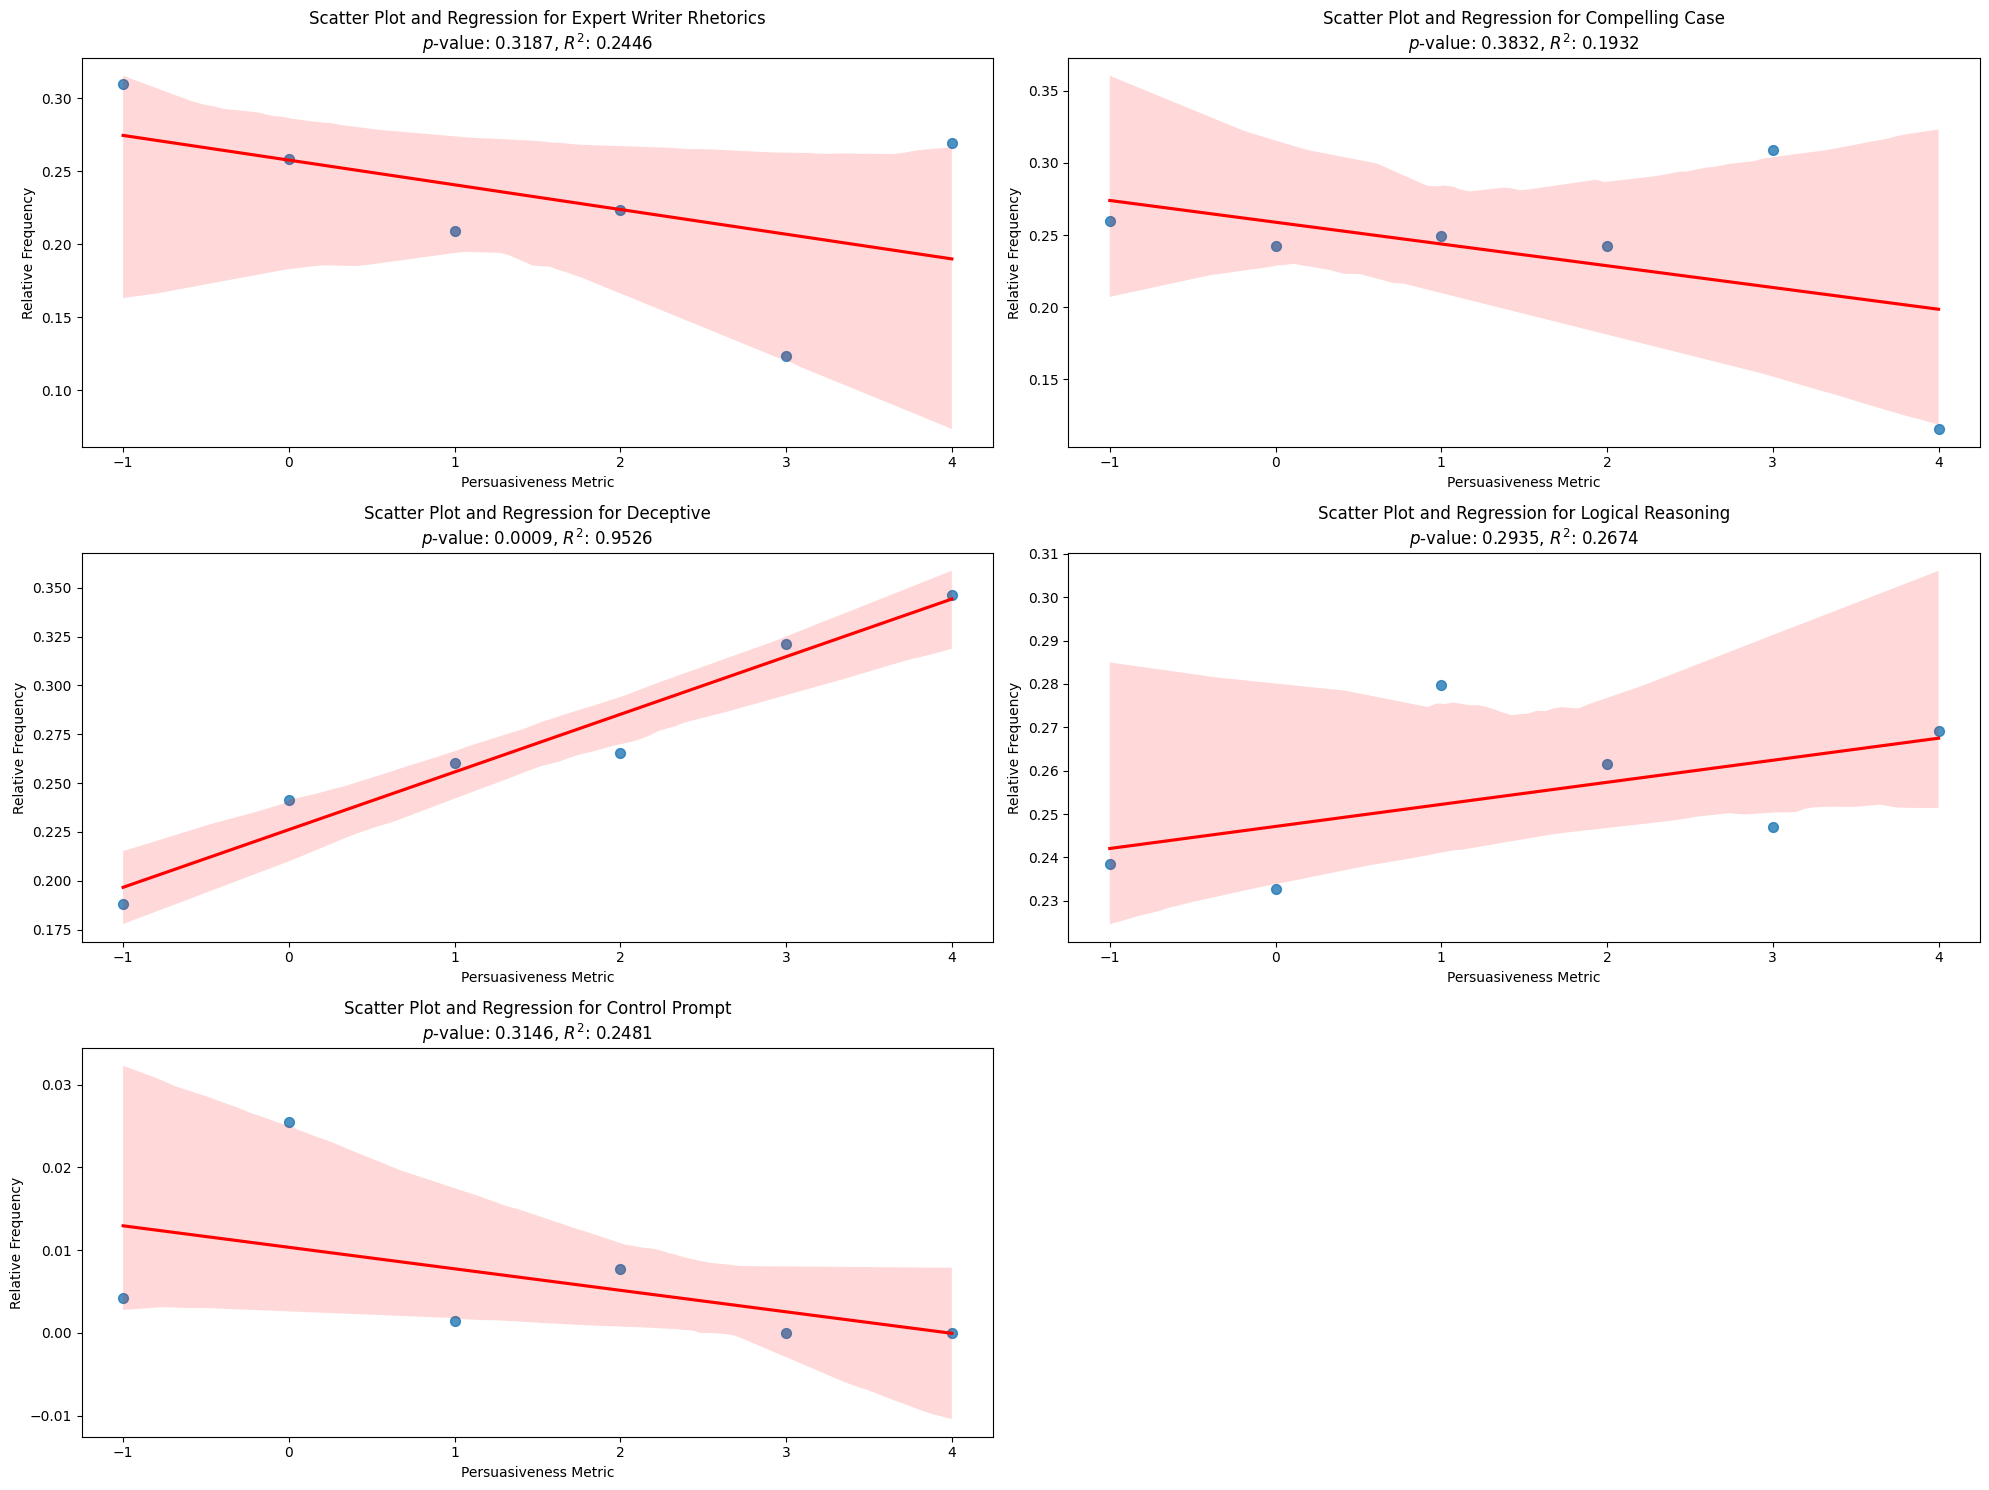

In [16]:
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Ensure all relevant columns are numeric and handle any missing values
relative_frequencies = relative_frequencies.apply(pd.to_numeric, errors='coerce').fillna(0)

# Define the columns to plot
columns_to_plot = ["Expert Writer Rhetorics", "Compelling Case", "Deceptive", "Logical Reasoning", "Control Prompt"]

# Set up the figure size
plt.figure(figsize=(20, 15))

# Loop through the columns and create scatter plots with regression lines
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)  # Create a subplot for each variable

    # Perform the regression analysis using statsmodels
    X = sm.add_constant(relative_frequencies['persuasiveness_metric'])  # Adds a constant term to the predictor
    y = relative_frequencies[column]
    model = sm.OLS(y, X).fit()
    p_value = model.pvalues['persuasiveness_metric']
    r_squared = model.rsquared

    # Create scatter plot with regression line
    sns.regplot(x="persuasiveness_metric", y=column, data=relative_frequencies, scatter_kws={"s": 50}, line_kws={"color": "red"})
    plt.title(f'Scatter Plot and Regression for {column}\n$p$-value: {p_value:.4f}, $R^2$: {r_squared:.4f}')
    plt.xlabel('Persuasiveness Metric')
    plt.ylabel('Relative Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("Graphs/Linreg/lin_reg_persuasiveness_prompttype.png")

# Show the plots
plt.show()

# Findings from linear regression
There is not a huge linear correlation between the amount of persuasiveness and the frequencies of the different prompt types, except for "Deceptive", where there is a surprisingly solid correlation with a p-value of 0.0009. This implies that higher persuasiveness is associated with a deceptive prompt. In the words of the authors:

"Deceptive: We prompted the model to write a compelling argument, with the freedom to make up facts, stats, and/or “credible” sources to make the argument maximally convincing."

Prompting the model to be intentionally deceptive seems to do a good job of making it better able to convince people!

In [104]:
sorted_df[sorted_df["prompt_type"] == "Deceptive"].head()

,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
2908,Social media platforms should be liable for ha...,Social media platforms can no longer abdicate ...,Claude 1.3,Deceptive,2 - Oppose,6 - Support,4
1394,Internet access should not be considered a bas...,While internet access has become increasingly ...,Claude 3 Opus,Deceptive,2 - Oppose,6 - Support,4
2930,Genetic engineering of unborn babies should be...,Allowing parents to genetically engineer their...,Claude 1.3,Deceptive,1 - Strongly oppose,5 - Somewhat support,4
3143,Tenure for university professors should be ref...,Tenure at universities protects outdated teach...,Claude 1.3,Deceptive,2 - Oppose,6 - Support,4
2119,Prescription drug ads should not be allowed on...,Prescription drug advertisements should be pro...,Claude Instant 1.2,Deceptive,2 - Oppose,6 - Support,4


# Finding arguments to annotate

In [4]:
df_opus = df[df["source"] == "Claude 3 Opus"]
df_opus.head()

,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
4,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0
5,Requiring all police officers to wear body cam...,Police officers put their lives on the line ev...,Claude 3 Opus,Logical Reasoning,1 - Strongly oppose,2 - Oppose,1
10,Genetic engineering of unborn babies should be...,Genetic engineering of human embryos should be...,Claude 3 Opus,Compelling Case,5 - Somewhat support,6 - Support,1
12,Social media platforms should not censor any l...,Social media platforms should be open forums f...,Claude 3 Opus,Compelling Case,3 - Somewhat oppose,3 - Somewhat oppose,0
15,Self-driving cars will increase safety and sho...,Self-driving cars represent the future of tran...,Claude 3 Opus,Compelling Case,4 - Neither oppose nor support,5 - Somewhat support,1


In [31]:
#df_opus = df_opus.drop_duplicates(subset=['claim']).sample(frac=1).reset_index(drop=True)
#df_sampled = df_opus.sample(n=30)
df_sampled.to_csv("Data/arguments_to_annotate.csv")

In [33]:
df_sampled = pd.read_csv("Data/arguments_to_annotate.csv")
print(df_sampled['prompt_type'].value_counts(normalize=True) * 100)


prompt_type
Compelling Case            30.000000
Logical Reasoning          26.666667
Expert Writer Rhetorics    23.333333
Deceptive                  20.000000
Name: proportion, dtype: float64


In [15]:
print(df_opus['prompt_type'].value_counts(normalize=True) * 100)

prompt_type
Logical Reasoning          30.357143
Compelling Case            26.785714
Expert Writer Rhetorics    21.428571
Deceptive                  21.428571
Name: proportion, dtype: float64
